**MAESTRÍA EN INTELIGENCIA ARTIFICIAL APLICADA**

**Curso: MR4010.10 - Navegación Auronoma**

Tecnológico de Monterrey

Prof David Antonio Torres

**Semana 7**
Actividad 4.2 - Detección de Señales de Tránsito

---

*   NOMBRE: Henry José Requena Molina
*   MATRÍCULA:

*   NOMBRE: Ariel Mora Monroy
*   MATRÍCULA:

*   NOMBRE: Abel Jhoan Díaz Escalera
*   MATRÍCULA:

*   NOMBRE: Jose Antonio Toledo Gonzalez
*   MATRÍCULA: A01796592

In [40]:
# Librerias a usar
%pip install numpy==1.26.4
%pip install imgaug
import cv2
import keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, SpatialDropout2D
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from time import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import glob
from sklearn.preprocessing import MinMaxScaler
import imgaug.augmenters as iaa
import random
%matplotlib inline

In [4]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


Recorte: x1=16, y1=64, ancho=288, alto=96


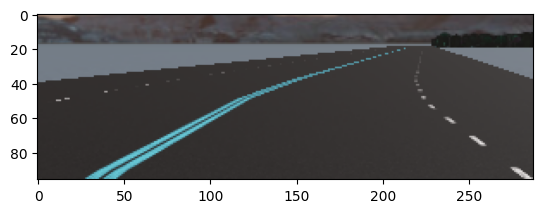

In [5]:
webots = glob.glob("/content/drive/MyDrive/Colab Notebooks/Navegacion Autonoma/Semana10/NAVEGACIÓN AUTÓNOMA /Dataset/dataset_images1/*.png")

# webots = glob.glob("C:/Users/anton/Desktop/Dataset/dataset_images1/*.png")
height, width = cv2.imread(webots[0]).shape[:2]
ratio = 3  # Ancho 3 veces el alto
# Definir ancho deseado (puede ser una fracción del ancho original)
desired_width = int(0.9 * width)  # 90% del ancho original, por ejemplo
desired_height = int(desired_width / ratio)

x1 = (width - desired_width) // 2
y1 = height - desired_height
print(f"Recorte: x1={x1}, y1={y1}, ancho={desired_width}, alto={desired_height}")

plt.imshow(cv2.imread(webots[0])[y1:, x1:x1 + desired_width])

In [6]:
def zoom(image):
  zoom = iaa.Affine(scale=(1, 1.3))
  image = zoom.augment_image(image)
  return image

def pan(image):
  pan = iaa.Affine(translate_percent= {"x" : (-0.1, 0.1), "y": (-0.1, 0.1)})
  image = pan.augment_image(image)
  return image

def img_random_brightness(image):
  brightness = iaa.Multiply((0.7, 1.1))
  image = brightness.augment_image(image)
  return image

def img_random_flip(image, steering_angle):
  image = cv2.flip(image,1)
  steering_angle = -steering_angle
  return image, steering_angle

def random_augment(image, steering_angle):
  if np.random.rand() < 0.5:
      image = pan(image)
  if np.random.rand() < 0.5:
      image = zoom(image)
  if np.random.rand() < 0.5:
      image = img_random_brightness(image)
  if np.random.rand() < 0.5:
      image, steering_angle = img_random_flip(image,steering_angle)
  return image, steering_angle

def img_preprocess(img):
  # img = img[60:135,:,:]
  img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
  img = cv2.GaussianBlur(img, (3, 3), 0)
  img = cv2.resize(img, (200, 66))
  # img = img/255
  return img

In [15]:
webots = glob.glob("/content/drive/MyDrive/Colab Notebooks/Navegacion Autonoma/Semana10/NAVEGACIÓN AUTÓNOMA /Dataset/dataset_images1/*.png")
print("Screens - ", len(webots))

csv = "/content/drive/MyDrive/Colab Notebooks/Navegacion Autonoma/Semana10/NAVEGACIÓN AUTÓNOMA /Dataset/dataset_labels1.csv"

# webots = glob.glob("C:/Users/anton/Desktop/Dataset/dataset_images1/*.png")
# print("Screens - ", len(webots))

# csv = "C:/Users/anton/Desktop/Dataset/dataset_labels1.csv"

dataset_webots = []
y = np.array([])

df = pd.read_csv(csv)
df['image_path'] = df['image_path'].str.split("\\").str[-1]

for i in webots:
  img_color = mpimg.imread(i)
  img_color = img_color[y1:, x1:x1 + desired_width, :]
  # img_resized = cv2.resize(img_color, fixed_size)

  img_pan  = pan(img_color)

  img_brightness = img_random_brightness(img_pan)

  # img_gray = cv2.cvtColor(img_brightness, cv2.COLOR_RGB2GRAY)
  # print("Nombre: ",i , " --- Size", img_gray.shape)\

  img_prepro = img_preprocess(img_brightness)

  i = i.split("/")[-1]
  # steering_angle = float(df[df['image_path'] == i]['steering_angle'])
  # print(i)

  if i in df['image_path'].values:
    dataset_webots.append(img_prepro)
    steering_angle = round(df[df['image_path'] == i]['steering_angle'], 4)
    # print(y)
    y = np.append(y, steering_angle)

print(len(dataset_webots))
print(y.shape)


Screens -  14430
14410
(14410,)


In [16]:
print(i)

2025-06-20_20-52-33_101.png


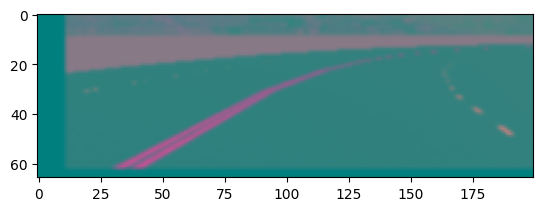

In [17]:
plt.imshow(dataset_webots[1000])

In [18]:
X = np.array(dataset_webots).astype('float32')
X = X.reshape(-1, X.shape[1], X.shape[2], 3)
print('X : ', X.shape)
print('Y : ', y.shape)

X :  (14410, 66, 200, 3)
Y :  (14410,)


(array([ 811.,  478.,  654.,  667., 2328., 4588., 1303.,  970.,  823.,
        1788.]),
 array([-0.12 , -0.096, -0.072, -0.048, -0.024,  0.   ,  0.024,  0.048,
         0.072,  0.096,  0.12 ]),
 <BarContainer object of 10 artists>)

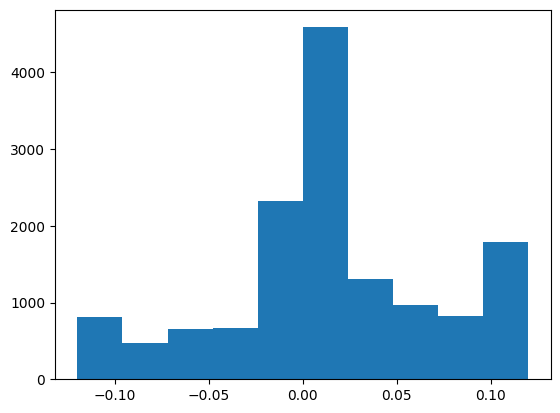

In [19]:
plt.hist(y)

In [20]:
zero_indices = np.where((y <= 0.007) & (y >= -0.007))[0]
print("Number of zero indices: ", len(zero_indices))

n_remove = int(len(zero_indices) * 0.75)
print("Number of zero indices to remove: ", n_remove)

remove_indices = np.random.choice(zero_indices, n_remove, replace=False)

mask = np.ones(len(y), dtype=bool)
mask[remove_indices] = False

x_filtrado = X[mask]
y_filtrado = y[mask]



Number of zero indices:  4864
Number of zero indices to remove:  3648


(array([ 419.,  101.,  114.,   81.,   96.,   87.,  100.,   93.,   99.,
          99.,  119.,  129.,  119.,  159.,  127.,  133.,  111.,  142.,
         127.,  153.,  171.,  190.,  229.,  226.,  342.,  743.,  327.,
         426.,  316.,  295.,  286.,  294.,  284.,  232.,  207.,  203.,
         210.,  191.,  182.,  188.,  170.,  156.,  170.,  177.,  151.,
         185.,  154.,  165.,  149., 1135.]),
 array([-0.12  , -0.1152, -0.1104, -0.1056, -0.1008, -0.096 , -0.0912,
        -0.0864, -0.0816, -0.0768, -0.072 , -0.0672, -0.0624, -0.0576,
        -0.0528, -0.048 , -0.0432, -0.0384, -0.0336, -0.0288, -0.024 ,
        -0.0192, -0.0144, -0.0096, -0.0048,  0.    ,  0.0048,  0.0096,
         0.0144,  0.0192,  0.024 ,  0.0288,  0.0336,  0.0384,  0.0432,
         0.048 ,  0.0528,  0.0576,  0.0624,  0.0672,  0.072 ,  0.0768,
         0.0816,  0.0864,  0.0912,  0.096 ,  0.1008,  0.1056,  0.1104,
         0.1152,  0.12  ]),
 <BarContainer object of 50 artists>)

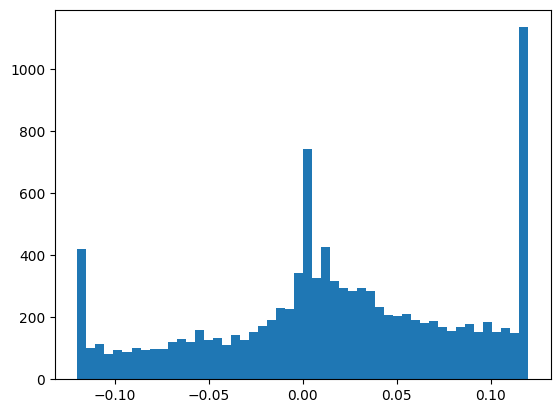

In [21]:
plt.hist(y_filtrado, bins=50)

In [22]:
scale = MinMaxScaler(feature_range=(-1, 1))
balanced_y = scale.fit_transform(y_filtrado.reshape(-1, 1)).flatten()
print("Balanced y shape: ", balanced_y.shape)


Balanced y shape:  (10762,)


(array([ 421.,   99.,  114.,   87.,   90.,   88.,  100.,   96.,   95.,
          99.,  119.,  129.,  123.,  159.,  123.,  135.,  113.,  138.,
         130.,  152.,  169.,  192.,  235.,  213.,  347.,  751.,  335.,
         415.,  311.,  295.,  286.,  294.,  289.,  230.,  209.,  198.,
         210.,  191.,  182.,  189.,  173.,  152.,  170.,  177.,  151.,
         185.,  156.,  163.,  149., 1135.]),
 array([-1.  , -0.96, -0.92, -0.88, -0.84, -0.8 , -0.76, -0.72, -0.68,
        -0.64, -0.6 , -0.56, -0.52, -0.48, -0.44, -0.4 , -0.36, -0.32,
        -0.28, -0.24, -0.2 , -0.16, -0.12, -0.08, -0.04,  0.  ,  0.04,
         0.08,  0.12,  0.16,  0.2 ,  0.24,  0.28,  0.32,  0.36,  0.4 ,
         0.44,  0.48,  0.52,  0.56,  0.6 ,  0.64,  0.68,  0.72,  0.76,
         0.8 ,  0.84,  0.88,  0.92,  0.96,  1.  ]),
 <BarContainer object of 50 artists>)

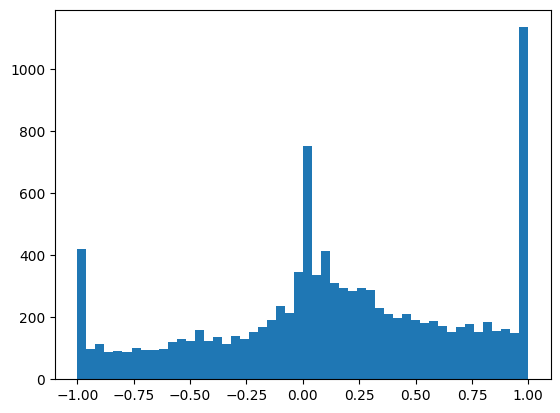

In [23]:
plt.hist(balanced_y, bins=50)

In [24]:
x_train, x_test, y_train, y_test = train_test_split(x_filtrado, balanced_y, test_size=0.2, random_state=42)

print("Formato del array de imagenes de entrenamiento: ",x_train.shape)
print("Formato del array de los labels de entrenamiento: ", y_train.shape)
print("Formato del array de imagenes de prueba: ",x_test.shape)
print("Formato del aaray de los labels de prueba: ", y_test.shape)

Formato del array de imagenes de entrenamiento:  (8609, 66, 200, 3)
Formato del array de los labels de entrenamiento:  (8609,)
Formato del array de imagenes de prueba:  (2153, 66, 200, 3)
Formato del aaray de los labels de prueba:  (2153,)


In [52]:
# Declaración de nuestros dos mejores modelos para entrenar e hiperparametros para el modelo


def create_model_bn_5_dropout():

  model = Sequential()
  # Convolutional layers
  model.add(Conv2D(filters=20, kernel_size=(3, 3), activation='elu', input_shape=(66,200,3), padding="same"))
  model.add(BatchNormalization())
  model.add(Conv2D(filters=20, kernel_size=(3, 3), activation='elu', input_shape=(66,200,3), padding="same"))
  model.add(BatchNormalization())
  model.add(MaxPooling2D())
  model.add(SpatialDropout2D(0.25))

  model.add(Conv2D(filters=40, kernel_size=(3, 3), activation='elu', padding="same"))
  model.add(Conv2D(filters=40, kernel_size=(3, 3), activation='elu', padding="same"))
  model.add(BatchNormalization())
  model.add(MaxPooling2D())
  model.add(SpatialDropout2D(0.2))

  model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='elu', padding="same"))
  model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='elu', padding="same"))
  model.add(BatchNormalization())
  model.add(MaxPooling2D())
  model.add(Dropout(0.15))

  # Fully Connected layers
  model.add(Flatten())
  model.add(Dense(units=384, activation='elu'))
  model.add(Dropout(0.5))
  model.add(Dense(units=192, activation='elu'))
  model.add(Dropout(0.2))
  model.add(Dense(units=1, activation='softmax'))

  return model

def create_model_bn_6_dropout():

  model = Sequential()
  # Convolutional layers
  model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='elu', input_shape=x_train.shape[1:], padding="same"))
  model.add(BatchNormalization())
  model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='elu', input_shape=x_train.shape[1:], padding="same"))
  model.add(BatchNormalization())
  model.add(AveragePooling2D())
  model.add(SpatialDropout2D(0.2))

  model.add(Conv2D(filters=48, kernel_size=(3, 3), activation='elu', padding="same"))
  model.add(BatchNormalization())
  model.add(Conv2D(filters=48, kernel_size=(3, 3), activation='elu', padding="same"))
  model.add(BatchNormalization())
  model.add(AveragePooling2D())
  model.add(SpatialDropout2D(0.2))

  model.add(Conv2D(filters=72, kernel_size=(3, 3), activation='elu', padding="same"))
  model.add(BatchNormalization())
  model.add(Conv2D(filters=72, kernel_size=(3, 3), activation='elu', padding="same"))
  model.add(BatchNormalization())
  model.add(AveragePooling2D())
  model.add(Dropout(0.1))

  # Fully Connected layers
  model.add(Flatten())
  model.add(Dense(units=384, activation='elu'))
  model.add(Dropout(0.5))
  model.add(Dense(units=192, activation='elu'))
  model.add(Dropout(0.1))
  model.add(Dense(units=1))

  return model

def nvidia_model():
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Convolution2D(24, (5, 5), strides=(2, 2), input_shape=(66, 200, 3), activation='elu'))
  model.add(tf.keras.layers.Convolution2D(36, (5, 5), strides=(2, 2), activation='elu'))
  model.add(tf.keras.layers.Convolution2D(48, (5, 5), strides=(2, 2), activation='elu'))
  model.add(tf.keras.layers.Convolution2D(64, (3, 3), activation='elu'))
  model.add(tf.keras.layers.Convolution2D(64, (3, 3), activation='elu'))
  # model.add(tf.keras.layers.Dropout(0.5))
  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(100, activation = 'elu'))
  model.add(tf.keras.layers.Dense(50, activation = 'elu'))
  model.add(tf.keras.layers.Dense(1, activation = 'linear')) # Changed to 1 unit and linear activation for regression
  # optimizer = Adam(lr=1e-3)
  # model.compile(loss='mse', optimizer=optimizer)
  return model

In [53]:
batch_size = 100
steps_per_epoch = 300
epochs = 50
augment = False
validation_steps = 200
patience = 10

datagen = ImageDataGenerator(rotation_range=15, width_shift_range=[-5, 0, 5], horizontal_flip=True)

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.0005, patience=patience, restore_best_weights=True, verbose=1)

# Escoge el modelo a usar
model = nvidia_model()
model.summary()
# Learning rate para nuestro optimizador Adam
opt = Adam(learning_rate=0.0001)

#Compilamos
model.compile(loss='mse', optimizer=opt)
start = time()
if augment:
  it_train = datagen.flow(x_train, y_train, batch_size=batch_size)
  history_object = model.fit(it_train, steps_per_epoch=steps_per_epoch, epochs=epochs, validation_data=(x_test, y_test), validation_steps=validation_steps, shuffle=True, callbacks=[early_stopping])
else:
  history_object = model.fit(x_train, y_train, batch_size=batch_size, steps_per_epoch=steps_per_epoch, epochs=epochs, validation_data=(x_test, y_test), validation_steps=validation_steps, shuffle=True, callbacks=[early_stopping])
print("Training time:", time()-start)




/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_39 (Conv2D)              │ (None, 31, 98, 24)     │         1,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_40 (Conv2D)              │ (None, 14, 47, 36)     │        21,636 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_41 (Conv2D)              │ (None, 5, 22, 48)      │        43,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_42 (Conv2D)              │ (None, 3, 20, 64)      │        27,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_43 (Conv2D)              │ (None, 1, 18, 64)      │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 100)            │       115,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 251,749 (983.39 KB)

 Trainable params: 251,749 (983.39 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
 87/300 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.2406

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


300/300 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss: 0.1976 - val_loss: 0.1302
Epoch 2/50
 13/300 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.1287

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1210 - val_loss: 0.1255


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


Epoch 3/50
 81/300 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.1180

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1108 - val_loss: 0.1045
Epoch 4/50
 86/300 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.1015 

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1009 - val_loss: 0.1011
Epoch 5/50
 85/300 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0980

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0964 - val_loss: 0.0986
Epoch 6/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0905 - val_loss: 0.0967


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


Epoch 7/50
 82/300 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0903

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0892 - val_loss: 0.0905
Epoch 8/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0868 - val_loss: 0.0889


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


Epoch 9/50
 81/300 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0841

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0839 - val_loss: 0.0903
Epoch 10/50
 13/300 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0849

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0844 - val_loss: 0.0877
Epoch 11/50
 13/300 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0752

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0818 - val_loss: 0.0874
Epoch 12/50
 19/300 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0779

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0811 - val_loss: 0.0856
Epoch 13/50
 13/300 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0726

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0792 - val_loss: 0.0872
Epoch 14/50
 13/300 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0744

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0806 - val_loss: 0.0881
Epoch 15/50
 19/300 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0801

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0780 - val_loss: 0.0852
Epoch 16/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0774 - val_loss: 0.0853
Epoch 17/50
 13/300 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0795

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


 82/300 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0771

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0769 - val_loss: 0.0848
Epoch 18/50
 84/300 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0770

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0762 - val_loss: 0.0830
Epoch 19/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0756 - val_loss: 0.0854
Epoch 20/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


 86/300 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0760 

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0753 - val_loss: 0.0829
Epoch 21/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0737 - val_loss: 0.0823


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


Epoch 22/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0727 - val_loss: 0.0817


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


Epoch 23/50
 81/300 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0715 

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0721 - val_loss: 0.0822
Epoch 24/50
 13/300 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0783

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0741 - val_loss: 0.0843
Epoch 25/50
 13/300 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0682

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0716 - val_loss: 0.0812
Epoch 26/50
 13/300 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0687

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0705 - val_loss: 0.0849
Epoch 27/50
 83/300 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0706

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0703 - val_loss: 0.0877
Epoch 28/50
 13/300 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0742

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0700 - val_loss: 0.0833
Epoch 29/50
 13/300 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0748

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0704 - val_loss: 0.0820
Epoch 30/50
 81/300 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0722

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0704 - val_loss: 0.0811
Epoch 31/50
 19/300 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0631

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0680 - val_loss: 0.0808
Epoch 32/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0670 - val_loss: 0.0831
Epoch 33/50
 81/300 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0700

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0686 - val_loss: 0.0793
Epoch 34/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0670 - val_loss: 0.0808
Epoch 35/50
 13/300 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0696

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0673 - val_loss: 0.0829
Epoch 36/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0650 - val_loss: 0.0775
Epoch 37/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0648 - val_loss: 0.0841
Epoch 38/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0660 - val_loss: 0.0842
Epoch 39/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0646 - val_loss: 0.0784
Epoch 40/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0646 - val_loss: 0.0809
Epoch 41/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0639 - val_loss: 0.0782
Epoch 42/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0617 - val_loss: 0.0792
Epoch 43/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0618 - val_loss: 0.0779
Epoch 44/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0617 - val_loss: 0.0810
Epoch 45/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0621 - val_loss: 0.0777
Epoch 46/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0610 - val_loss: 0.0781
Epoch 46: early stopping
Restoring model weights from the end of the best epoch: 36.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


Training time: 55.25790858268738


68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0772
Test loss: 0.07745259255170822


Text(0.5, 0, 'epoch')

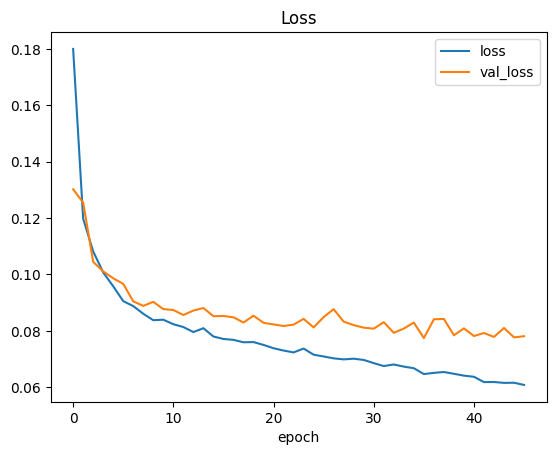

In [55]:
# Realizamos las preubas para calificar nuestro modelo acorde a las perdidas de nuestro dataset de entrenamiento y de test
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores)

plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.title('Loss')
plt.xlabel('epoch')

68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


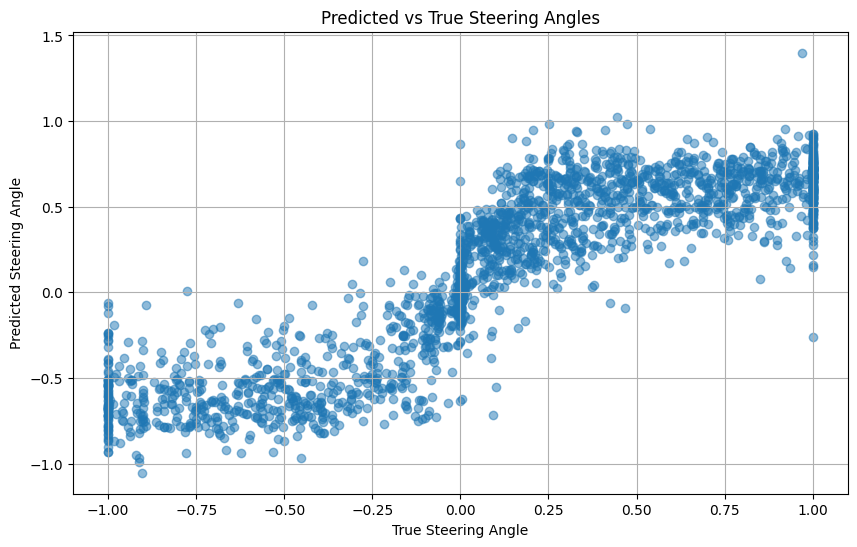

In [59]:
# Realizamos las preubas para calificar nuestro modelo acorde a las perdidas de nuestro dataset de entrenamiento y de test
y_predict = model.predict(x_test)
# y_predict = np.argmax(y_predict, axis=1) # Not needed for regression

# y_test_labels = np.argmax(y_test, axis=1) # Not needed for regression

# print(classification_report(y_test_labels, y_predict)) # Not applicable for regression
# cm = confusion_matrix(y_test_labels, y_predict) # Not applicable for regression

# plt.figure(figsize=(12, 10))
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test_labels)) # Not applicable for regression
# disp.plot(cmap=plt.cm.Blues, ax=plt.gca()) # Not applicable for regression
# plt.title('Matriz de Confusión') # Not applicable for regression
# plt.xlabel('Predicciones') # Not applicable for regression
# plt.ylabel('Valores Reales') # Not applicable for regression
# plt.show() # Not applicable for regression

# Visualize predicted vs true steering angles with a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_predict, alpha=0.5)
plt.title('Predicted vs True Steering Angles')
plt.xlabel('True Steering Angle')
plt.ylabel('Predicted Steering Angle')
plt.grid(True)
plt.show()

In [61]:
model.save('model1.h5')